## **Imports**

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB3, ResNet50
import warnings
warnings.filterwarnings("ignore")

## **Getting Data**

In [ ]:
from IPython.display import clear_output
!pip install --upgrade kaggle clear_output()
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
   print('User uploaded file "{name}" with length {length} bytes'.format( name=fn, length=len(uploaded[fn])))
   !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install --upgrade kaggle clear_output()'


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 88% 30.0M/34.1M [00:01<00:00, 33.9MB/s]
100% 34.1M/34.1M [00:01<00:00, 23.5MB/s]


In [ ]:
!unzip -qx /content/alzheimers-dataset-4-class-of-images.zip

## **Plotting Data Distribution**

In [ ]:
class_names = os.listdir('/content/Alzheimer_s Dataset/train')
class_sizes = list(map(lambda name: len(os.listdir(name)), g.glob('/content/Alzheimer_s Dataset/train/*')))
print('class names: ', class_names)
print('class size: ', class_sizes)

class names:  ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
class size:  [1792, 717, 52, 2560]


In [ ]:
data = {
    'Category': class_names,
    'Count': class_sizes }

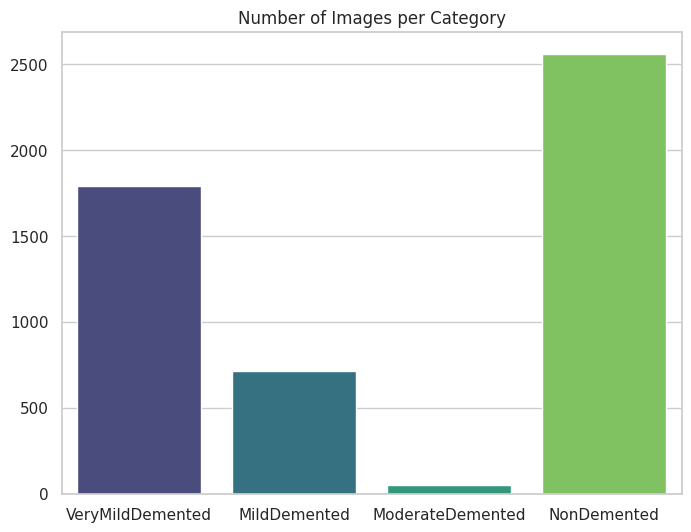

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=data, palette='viridis')
ax.set_title('Number of Images per Category')
plt.show()

## **Preparing Data**

In [ ]:
train = glob.glob("/content/Alzheimer_s Dataset/train/**/*.jpg")
test = glob.glob("/content/Alzheimer_s Dataset/test/**/*.jpg")

In [ ]:
print("There is {} images in the training dataset".format(len(train)))
print("There is {} images in the test dataset".format(len(test)))

There is 5121 images in the training dataset
There is 1279 images in the test dataset


In [ ]:
directory = '/content/Alzheimer_s Dataset/'

datasets  = ["train", "test"]
Mild_Demented, Moderate_Demented, Non_Demented, VeryMild_Demented = [], [], [], []

for i in datasets:
    path = os.path.join(directory, i)
    MildDemented = glob.glob(os.path.join(path, "MildDemented/*.jpg"))
    ModerateDemented = glob.glob(os.path.join(path, "ModerateDemented/*.jpg"))
    NonDemented = glob.glob(os.path.join(path, "NonDemented/*.jpg"))
    VeryMildDemented = glob.glob(os.path.join(path, "VeryMildDemented/*.jpg"))
    Mild_Demented.extend(MildDemented), Moderate_Demented.extend(ModerateDemented), Non_Demented.extend(NonDemented), VeryMild_Demented.extend(VeryMildDemented)

print("The number of MildDemented images is: {}".format(len(Mild_Demented)))
print("The number of ModerateDemented images is: {}".format(len(Moderate_Demented)))
print("The number of NonDemented images is: {}".format(len(Non_Demented)))
print("The number of VeryMildDemented images is: {}".format(len(VeryMild_Demented)))

The number of MildDemented images is: 896
The number of ModerateDemented images is: 64
The number of NonDemented images is: 3200
The number of VeryMildDemented images is: 2240


In [ ]:
dataset_dir = '/content/Alzheimer_s Dataset/'
categories = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
image_paths = []
labels = []

for category in categories:
    for split in ['train', 'test']:
        category_dir = os.path.join(dataset_dir, split, category)
        for image_name in os.listdir(category_dir):
            image_path = os.path.join(category_dir, image_name)
            image_paths.append(image_path)
            labels.append(category)

data = pd.DataFrame({'image_path': image_paths, 'label': labels})
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(train_df.head())
print('-' * 20)
print(test_df.head())

                                          image_path             label
0  /content/Alzheimer_s Dataset/train/NonDemented...       NonDemented
1  /content/Alzheimer_s Dataset/train/VeryMildDem...  VeryMildDemented
2  /content/Alzheimer_s Dataset/train/NonDemented...       NonDemented
3  /content/Alzheimer_s Dataset/train/MildDemente...      MildDemented
4  /content/Alzheimer_s Dataset/train/VeryMildDem...  VeryMildDemented
--------------------
                                          image_path             label
0  /content/Alzheimer_s Dataset/train/VeryMildDem...  VeryMildDemented
1  /content/Alzheimer_s Dataset/train/VeryMildDem...  VeryMildDemented
2  /content/Alzheimer_s Dataset/test/MildDemented...      MildDemented
3  /content/Alzheimer_s Dataset/train/MildDemente...      MildDemented
4  /content/Alzheimer_s Dataset/train/MildDemente...      MildDemented


In [ ]:
print(len(train_df[train_df['label'] == 'NonDemented']))
print(len(train_df[train_df['label'] == 'VeryMildDemented']))
print(len(train_df[train_df['label'] == 'MildDemented']))
print(len(train_df[train_df['label'] == 'ModerateDemented']))

2560
1792
717
51


In [ ]:
import glob as g
class_names = train_df['label'].unique()
class_sizes= dict()
class_sizes['NonDemented'] = len(train_df[train_df['label'] == 'NonDemented'])
class_sizes['VeryMildDemented'] = len(train_df[train_df['label'] == 'VeryMildDemented'])
class_sizes['MildDemented'] = len(train_df[train_df['label'] == 'MildDemented'])
class_sizes['ModerateDemented'] = len(train_df[train_df['label'] == 'ModerateDemented'])
print('class names: ', class_names)
print('class size: ', class_sizes)

total_data = len(train_df)
dict_weights = dict()
j=0
for i in class_names:
  print(i)
  weight = round(total_data/(len(class_names) * class_sizes[i]),2)
  dict_weights[j] = weight
  j+=1
print(dict_weights)

class names:  ['NonDemented' 'VeryMildDemented' 'MildDemented' 'ModerateDemented']
class size:  {'NonDemented': 2560, 'VeryMildDemented': 1792, 'MildDemented': 717, 'ModerateDemented': 51}
NonDemented
VeryMildDemented
MildDemented
ModerateDemented
{0: 0.5, 1: 0.71, 2: 1.79, 3: 25.1}


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)
batch_size =16
target_size = (224, 224)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size,
    target_size=target_size
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    shuffle=False,
    class_mode='categorical',
    batch_size=batch_size,
    target_size=target_size
)

Found 5120 validated image filenames belonging to 4 classes.
Found 1280 validated image filenames belonging to 4 classes.


class names are ['NonDemented' 'VeryMildDemented' 'MildDemented' 'ModerateDemented']


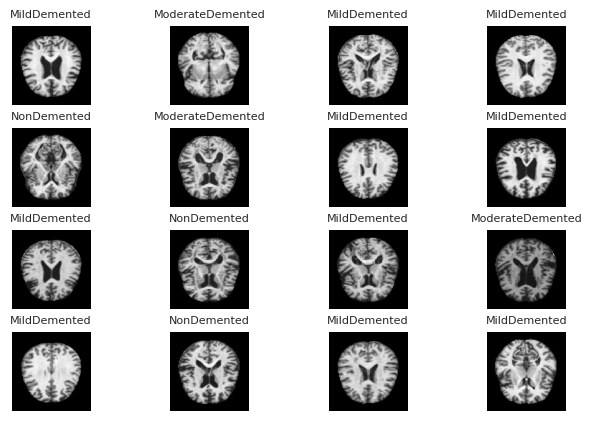

In [ ]:
print(f"class names are {class_names}")
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 5))
fig.subplots_adjust(wspace=0.1, hspace=0.3)

images, labels = next(train_generator)
for i in range(16):
    a = ax.flat[i]
    a.imshow(images[i], cmap='gray')
    a.set_title(class_names[np.argmax(labels[i])],fontsize = 8)
    a.set_axis_off()

plt.show()

## **CNN**

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224,224, 3)))
model.add(Conv2D(64, (3, 3),strides=2, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 flatten (Flatten)           (None, 774400)            0         
                                                                 
 dense (Dense)               (None, 128)               99123328  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, verbose = 1)

history = model.fit(train_generator,
    validation_data=test_generator,
    class_weight=dict_weights,
    epochs=30,
    callbacks = [early_stopping_callbacks])

Epoch 1/30
320/320 [==============================] - 31s 62ms/step - loss: 4.5084 - accuracy: 0.3529 - val_loss: 1.6510 - val_accuracy: 0.3500
Epoch 2/30
320/320 [==============================] - 19s 58ms/step - loss: 3.4461 - accuracy: 0.3500 - val_loss: 2.0556 - val_accuracy: 0.3500
Epoch 3/30
320/320 [==============================] - 18s 56ms/step - loss: 2.9247 - accuracy: 0.3568 - val_loss: 1.2087 - val_accuracy: 0.4359
Epoch 4/30
320/320 [==============================] - 18s 57ms/step - loss: 2.2381 - accuracy: 0.4797 - val_loss: 1.0768 - val_accuracy: 0.5625
Epoch 5/30
320/320 [==============================] - 18s 57ms/step - loss: 1.4928 - accuracy: 0.6641 - val_loss: 1.1038 - val_accuracy: 0.5703
Epoch 6/30
320/320 [==============================] - 19s 59ms/step - loss: 1.0173 - accuracy: 0.7363 - val_loss: 0.7088 - val_accuracy: 0.6734
Epoch 7/30
320/320 [==============================] - 18s 57ms/step - loss: 0.9765 - accuracy: 0.7623 - val_loss: 0.7116 - val_accuracy:

## **Res Net**

In [ ]:
rn_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model = Sequential()
model.add(rn_model)
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(4,activation='softmax'))

model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                         

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

#early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, verbose = 1)
def scheduler(epoch, lr):
    return lr*(0.1**(0.05*epoch))

my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
]

history = model.fit(train_generator,
    validation_data=test_generator,
    class_weight=dict_weights,
    epochs=30,
    callbacks = my_callbacks)

Epoch 1/30
320/320 [==============================] - 112s 202ms/step - loss: 8.1571 - accuracy: 0.3963 - val_loss: 1.1752 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 2/30
320/320 [==============================] - 65s 202ms/step - loss: 2.7135 - accuracy: 0.4789 - val_loss: 1.1143 - val_accuracy: 0.5000 - lr: 8.9125e-04
Epoch 3/30
320/320 [==============================] - 66s 208ms/step - loss: 2.6311 - accuracy: 0.4803 - val_loss: 2.1683 - val_accuracy: 0.3531 - lr: 7.0795e-04
Epoch 4/30
320/320 [==============================] - 67s 208ms/step - loss: 1.7079 - accuracy: 0.6535 - val_loss: 6.2716 - val_accuracy: 0.4148 - lr: 5.0119e-04
Epoch 5/30
320/320 [==============================] - 67s 208ms/step - loss: 1.3338 - accuracy: 0.7111 - val_loss: 5.2652 - val_accuracy: 0.3508 - lr: 3.1623e-04
Epoch 6/30
320/320 [==============================] - 67s 209ms/step - loss: 0.7571 - accuracy: 0.7949 - val_loss: 0.5902 - val_accuracy: 0.7914 - lr: 1.7783e-04
Epoch 7/30
320/320 [===========

## **Xception**

In [ ]:
x_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max',)
model = Sequential()
model.add(x_model)
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 21912620 (83.59 MB)
Trainable params: 21858092 (83.38 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

history = model.fit(train_generator,
    validation_data=test_generator,
    class_weight=dict_weights,
    epochs=30,
    callbacks = [early_stopping_callbacks])

Epoch 1/30
320/320 [==============================] - 118s 272ms/step - loss: 3.1685 - accuracy: 0.4252 - val_loss: 1.5984 - val_accuracy: 0.5109
Epoch 2/30
320/320 [==============================] - 86s 269ms/step - loss: 2.4025 - accuracy: 0.5393 - val_loss: 1.1119 - val_accuracy: 0.7063
Epoch 3/30
320/320 [==============================] - 86s 267ms/step - loss: 2.1629 - accuracy: 0.5840 - val_loss: 3.6010 - val_accuracy: 0.3750
Epoch 4/30
320/320 [==============================] - 86s 268ms/step - loss: 1.6819 - accuracy: 0.6674 - val_loss: 1.0413 - val_accuracy: 0.7273
Epoch 5/30
320/320 [==============================] - 91s 283ms/step - loss: 1.3609 - accuracy: 0.7184 - val_loss: 2.7555 - val_accuracy: 0.3617
Epoch 6/30
320/320 [==============================] - 86s 268ms/step - loss: 1.1464 - accuracy: 0.7492 - val_loss: 1.7269 - val_accuracy: 0.6453
Epoch 7/30
320/320 [==============================] - 86s 268ms/step - loss: 1.2591 - accuracy: 0.7324 - val_loss: 2.5138 - val_a